In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os 
import json

from tqdm import tqdm

In [8]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [10]:
data_path = 'D:/nlp/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/nsmc/'
op = 'D:/nlp/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/nsmc/data_out/'

train_data = 'nsmc_train_input.npy'
label_data = 'nsmc_train_label.npy'
configs = 'data_configs.json'

In [12]:
seed = 1234
tf.random.set_seed(seed)

In [13]:
train_input = np.load(open(data_path + train_data, 'rb'))
label_input = np.load(open(data_path + label_data, 'rb'))
configs = json.load(open(data_path + configs, 'r'))

In [29]:
print(train_input.shape)
print(label_input.shape)
print(configs['vocab_size'])

(150000, 8)
(150000,)
43757


In [50]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 128
NUM_EPOCHS = 15
VALID_SPLIT = 0.2
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 36,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [51]:
# 모델

class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [52]:
model = CNNClassifier(**kargs)


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [53]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = op + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

D:/nlp/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/nsmc/data_out/cnn_classifier_kr -- Folder already exists 



In [54]:
history = model.fit(train_input, label_input, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/15
938/938 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.7879
Epoch 00001: val_accuracy improved from -inf to 0.82303, saving model to D:/nlp/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/nsmc/data_out/cnn_classifier_kr\weights.h5
938/938 [==============================] - 43s 46ms/step - loss: 0.4398 - accuracy: 0.7879 - val_loss: 0.3907 - val_accuracy: 0.8230
Epoch 2/15
937/938 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8520
Epoch 00002: val_accuracy improved from 0.82303 to 0.82763, saving model to D:/nlp/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/nsmc/data_out/cnn_classifier_kr\weights.h5
938/938 [==============================] - 43s 46ms/step - loss: 0.3411 - accuracy: 0.8520 - val_loss: 0.3855 - val_accuracy: 0.8276
Epoch 3/15
937/938 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8818
Epoch 00003: val_accuracy did not improve from 0.82763
938/938 [=============================

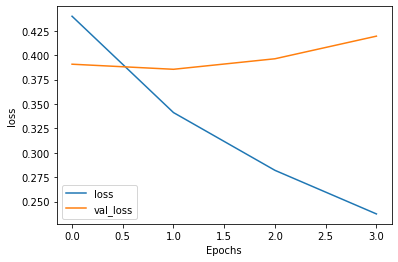

In [55]:
plot_graphs(history, 'loss')

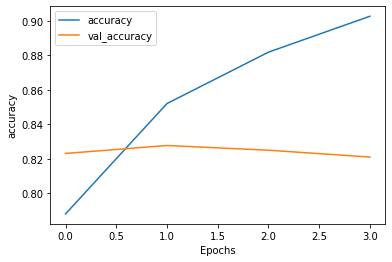

In [56]:
plot_graphs(history, 'accuracy')

In [47]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름


test_input = np.load(open(data_path + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(data_path + LABEL_TEST_DATA, 'rb'))

In [48]:
model.load_weights(os.path.join(op, model_name, SAVE_FILE_NM))

In [49]:
loss, acc =model.evaluate(test_input, test_label_data)
print("loss:", loss, "Acc:", acc)

1563/1563 [==============================] - 1s 875us/step - loss: 0.3900 - accuracy: 0.8272
loss: 0.3900211453437805 Acc: 0.8271999955177307
